ADE_val_00001001等。5张图片原图+标注图片

In [ ]:
from google.colab import drive  # 先导入 drive
drive.mount('/content/drive')
%cd drive/MyDrive/MSCS/260/ADE
%pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MSCS/260/ADE
ADE_val_00001001.jpg	  ADE_val_00001474_seg.png  backup
ADE_val_00001001_seg.png  ADE_val_00001608.jpg	    feature_diff_summary.csv
ADE_val_00001034.jpg	  ADE_val_00001608_seg.png  mask_metrics_img1.csv
ADE_val_00001034_seg.png  ADE_val_00001715.jpg	    mask_metrics_img2.csv
ADE_val_00001474.jpg	  ADE_val_00001715_seg.png



--- Processing Image 1: ADE_val_00001001.jpg ---
Displaying Image 1 and GT Mask...


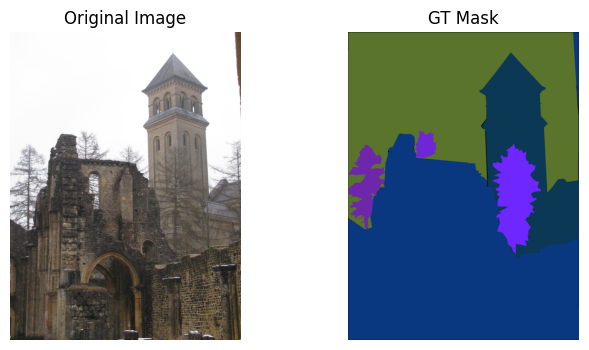


>>> Running precision: P3109
Precision P3109 done: Time=40.2187s, Pixel Acc=0.5667, Dice=0.5667, IoU=0.3954

>>> Running precision: FP32
Precision FP32 done: Time=573.3294s, Pixel Acc=0.5184, Dice=0.5184, IoU=0.3499

>>> Running precision: FP64
Precision FP64 done: Time=12.4960s, Pixel Acc=0.5156, Dice=0.5156, IoU=0.3474

>>> Running precision: TF32
Precision TF32 done: Time=651.4463s, Pixel Acc=0.5184, Dice=0.5184, IoU=0.3499

>>> Running precision: BFloat16
Precision BFloat16 done: Time=545.3465s, Pixel Acc=0.5190, Dice=0.5190, IoU=0.3505

--- Processing Image 2: ADE_val_00001474.jpg ---
Displaying Image 2 and GT Mask...


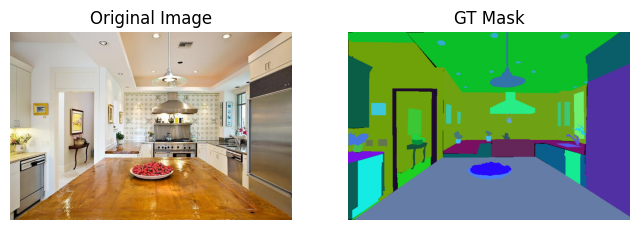


>>> Running precision: P3109
Precision P3109 done: Time=41.9271s, Pixel Acc=0.0020, Dice=0.0020, IoU=0.0010

>>> Running precision: FP32
Precision FP32 done: Time=605.3430s, Pixel Acc=0.0020, Dice=0.0020, IoU=0.0010

>>> Running precision: FP64
Precision FP64 done: Time=8.7436s, Pixel Acc=0.0020, Dice=0.0020, IoU=0.0010

>>> Running precision: TF32
Precision TF32 done: Time=620.0442s, Pixel Acc=0.0020, Dice=0.0020, IoU=0.0010

>>> Running precision: BFloat16
Precision BFloat16 done: Time=525.8178s, Pixel Acc=0.0020, Dice=0.0020, IoU=0.0010

--- Processing Image 3: ADE_val_00001715.jpg ---
Displaying Image 3 and GT Mask...


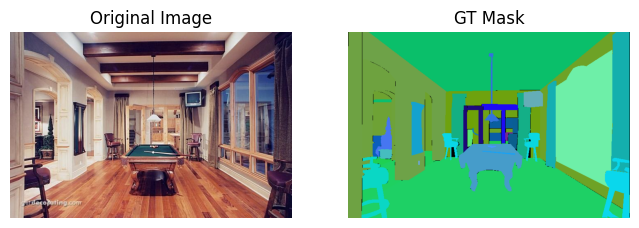


>>> Running precision: P3109
Precision P3109 done: Time=42.5494s, Pixel Acc=0.0082, Dice=0.0082, IoU=0.0041

>>> Running precision: FP32
Precision FP32 done: Time=591.3887s, Pixel Acc=0.0068, Dice=0.0068, IoU=0.0034

>>> Running precision: FP64
Precision FP64 done: Time=11.6071s, Pixel Acc=0.0068, Dice=0.0068, IoU=0.0034

>>> Running precision: TF32
Precision TF32 done: Time=606.7786s, Pixel Acc=0.0068, Dice=0.0068, IoU=0.0034

>>> Running precision: BFloat16
Precision BFloat16 done: Time=532.6403s, Pixel Acc=0.0068, Dice=0.0068, IoU=0.0034

--- Processing Image 4: ADE_val_00001608.jpg ---
Displaying Image 4 and GT Mask...


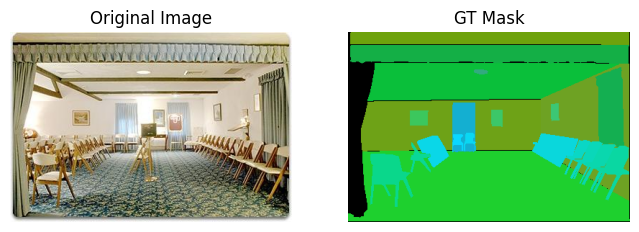


>>> Running precision: P3109
Precision P3109 done: Time=42.9305s, Pixel Acc=0.0123, Dice=0.0123, IoU=0.0062

>>> Running precision: FP32
Precision FP32 done: Time=570.8442s, Pixel Acc=0.0088, Dice=0.0088, IoU=0.0044

>>> Running precision: FP64
Precision FP64 done: Time=11.3685s, Pixel Acc=0.0087, Dice=0.0087, IoU=0.0044

>>> Running precision: TF32
Precision TF32 done: Time=550.4369s, Pixel Acc=0.0088, Dice=0.0088, IoU=0.0044

>>> Running precision: BFloat16
Precision BFloat16 done: Time=595.8912s, Pixel Acc=0.0088, Dice=0.0088, IoU=0.0044

--- Processing Image 5: ADE_val_00001034.jpg ---
Displaying Image 5 and GT Mask...


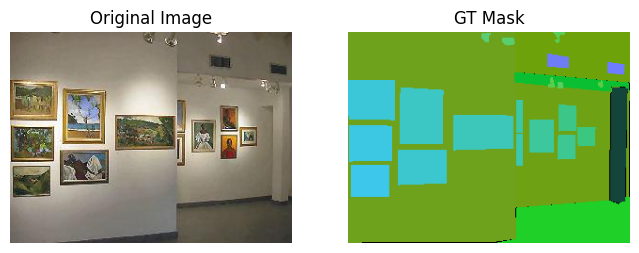


>>> Running precision: P3109
Precision P3109 done: Time=41.6964s, Pixel Acc=0.0032, Dice=0.0032, IoU=0.0016

>>> Running precision: FP32
Precision FP32 done: Time=533.6849s, Pixel Acc=0.0032, Dice=0.0032, IoU=0.0016

>>> Running precision: FP64
Precision FP64 done: Time=11.3660s, Pixel Acc=0.0032, Dice=0.0032, IoU=0.0016

>>> Running precision: TF32
Precision TF32 done: Time=605.9834s, Pixel Acc=0.0032, Dice=0.0032, IoU=0.0016

>>> Running precision: BFloat16
Precision BFloat16 done: Time=549.7048s, Pixel Acc=0.0032, Dice=0.0032, IoU=0.0016
 All images processed...


In [ ]:
# ============================================================
# SegFormer Multi-Precision + P3109 Quantization + Analysis
# Multi ADE20K images + GT masks
# ============================================================

import os
import time
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Core: P3109 simulation (vectorized, safe)
# -----------------------------
def float_to_p3109(x: torch.Tensor, K: int = 8, P: int = 3, rounding: str = "nearest_even", preserve_dtype: bool = True, eps: float = 1e-45) -> torch.Tensor:
    if P < 1:
        raise ValueError("P must be >= 1")
    e_bits = K - P
    if e_bits < 1:
        raise ValueError("K and P invalid: need at least 1 exponent bit")
    f_bits = P - 1

    bias = (2 ** (e_bits - 1)) - 1
    max_stored_exp = (2 ** e_bits) - 2
    E_max_unbiased = max_stored_exp - bias
    E_min_unbiased = 1 - bias

    orig_shape = x.shape
    orig_dtype = x.dtype
    work_dtype = torch.float32 if orig_dtype != torch.float64 else torch.float64
    x_work = x.flatten().to(work_dtype)

    n = x_work.numel()
    out_flat = torch.zeros_like(x_work)

    is_nan = torch.isnan(x_work)
    is_inf = torch.isinf(x_work)
    signbit = torch.signbit(x_work)
    absx = x_work.abs()
    is_zero = (absx == 0)

    out_flat[is_nan] = float('nan')
    out_flat[is_inf] = torch.sign(x_work[is_inf]) * float('inf')

    finite_mask = torch.isfinite(x_work) & (~is_zero) & (~is_nan) & (~is_inf)
    if finite_mask.any():
        xf = absx[finite_mask]
        m, e = torch.frexp(xf)
        mant = m * 2.0
        exp_unbiased = e - 1

        normal_mask = (exp_unbiased >= E_min_unbiased) & (exp_unbiased <= E_max_unbiased)
        subnormal_mask = exp_unbiased < E_min_unbiased
        overflow_mask = exp_unbiased > E_max_unbiased

        idxs = torch.arange(xf.shape[0], device=xf.device)
        if normal_mask.any():
            nm_idx = idxs[normal_mask]
            mant_n = mant[normal_mask]
            exp_n = exp_unbiased[normal_mask].to(torch.long)

            f = mant_n - 1.0
            scaled = f * (2.0 ** f_bits)
            if rounding == "nearest_even":
                scaled_q = torch.round(scaled)
            elif rounding == "toward_zero":
                scaled_q = torch.trunc(scaled)
            elif rounding == "floor":
                scaled_q = torch.floor(scaled)
            elif rounding == "ceil":
                scaled_q = torch.ceil(scaled)
            else:
                raise ValueError("Unsupported rounding")

            carry_mask = (scaled_q >= (2 ** f_bits))
            if carry_mask.any():
                scaled_q = scaled_q.clone()
                exp_n = exp_n.clone()
                scaled_q[carry_mask] = 0.0
                exp_n[carry_mask] = exp_n[carry_mask] + 1

            overflow_after = exp_n > E_max_unbiased
            mant_q = 1.0 + scaled_q / (2.0 ** f_bits)
            val_n = mant_q * (2.0 ** exp_n)
            if overflow_after.any():
                val_n[overflow_after] = float('inf')

            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            normal_positions = finite_positions[nm_idx]
            out_flat[normal_positions] = val_n

        if subnormal_mask.any():
            sm_idx = idxs[subnormal_mask]
            scaled_fraction = xf[subnormal_mask] / (2.0 ** E_min_unbiased) * (2.0 ** f_bits)
            if rounding == "nearest_even":
                frac_q = torch.round(scaled_fraction)
            elif rounding == "toward_zero":
                frac_q = torch.trunc(scaled_fraction)
            elif rounding == "floor":
                frac_q = torch.floor(scaled_fraction)
            elif rounding == "ceil":
                frac_q = torch.ceil(scaled_fraction)
            else:
                raise ValueError("Unsupported rounding")

            frac_q = torch.clamp(frac_q, 0.0, float(2 ** f_bits - 1))
            val_s = (frac_q / (2.0 ** f_bits)) * (2.0 ** E_min_unbiased)

            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            sub_positions = finite_positions[sm_idx]
            out_flat[sub_positions] = val_s

        if overflow_mask.any():
            ov_idx = idxs[overflow_mask]
            finite_positions = torch.nonzero(finite_mask, as_tuple=False).squeeze(1)
            ov_positions = finite_positions[ov_idx]
            out_flat[ov_positions] = float('inf')

    if signbit.any():
        out_flat[signbit] = -out_flat[signbit]

    if is_zero.any():
        zero_positions = torch.nonzero(is_zero, as_tuple=False).squeeze(1)
        out_flat[zero_positions] = x_work[zero_positions] * 0.0

    out = out_flat.view(orig_shape)
    return out.to(orig_dtype) if preserve_dtype else out

def float_to_p3109_safe(x, K=8, P=3, rounding="nearest_even", preserve_dtype=True):
    return float_to_p3109(x, K=K, P=P, rounding=rounding, preserve_dtype=preserve_dtype)

def quantize_model_p3109(model, K=8, P=3):
    for name, param in model.named_parameters():
        if param is None:
            continue
        with torch.no_grad():
            param.data.copy_(float_to_p3109_safe(param.data, K=K, P=P, preserve_dtype=True))
    return model

# -----------------------------
# Visualization utils
# -----------------------------
def visualize_comparison(original_image, pred_mask, title, save_path):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# -----------------------------
# Error metrics
# -----------------------------
def compute_error(a,b):
    a,b = a.float(), b.float()
    return {"MAE": float(torch.mean(torch.abs(a-b)).item()),
            "L2": float(torch.norm(a-b).item()),
            "MaxAbs": float(torch.max(torch.abs(a-b)).item())}

def dice_coeff(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    return (2.0 * intersection) / (pred_flat.numel() + target_flat.numel() + eps)

def iou_score(pred, target, eps=1e-6):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    intersection = (pred_flat == target_flat).sum().item()
    union = pred_flat.numel() + target_flat.numel() - intersection
    return intersection / (union + eps)

# -----------------------------
# ADE20K RGB mask -> class IDs
# -----------------------------
def ade20k_rgb_to_id(mask: Image.Image):
    mask_np = np.array(mask)
    H, W, _ = mask_np.shape
    class_map = np.zeros((H,W), dtype=np.int64)
    class_map[np.any(mask_np != 0, axis=2)] = 1
    return class_map

# -----------------------------
# Main experiment
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "nvidia/segformer-b2-finetuned-ade-512-512"

os.makedirs("pred_visualizations", exist_ok=True)
os.makedirs("features_cache", exist_ok=True)
os.makedirs("metrics_cache", exist_ok=True)

precisions = ["P3109","FP32","FP64","TF32","BFloat16"]

model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
processor = SegformerImageProcessor.from_pretrained(model_name)
model.eval()

image_mask_pairs = [
    ("ADE_val_00001001.jpg", "ADE_val_00001001_seg.png"),
    ("ADE_val_00001474.jpg", "ADE_val_00001474_seg.png"),
    ("ADE_val_00001715.jpg", "ADE_val_00001715_seg.png"),
    ("ADE_val_00001608.jpg", "ADE_val_00001608_seg.png"),
    ("ADE_val_00001034.jpg", "ADE_val_00001034_seg.png"),
]

feature_records = []

for idx, (img_path, mask_path) in enumerate(image_mask_pairs):
    print(f"\n--- Processing Image {idx+1}: {img_path} ---")
    # -----------------------------
# 检查图像和 mask 是否正确加载，并显示
# -----------------------------
    try:
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        print(f"Displaying Image {idx+1} and GT Mask...")
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(mask)
        plt.title("GT Mask")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error loading image or mask: {e}")
        continue


    inputs = processor(images=image, return_tensors="pt").to(device)
    all_features = {}
    all_metrics = {}
    timings = {}

    for p in precisions:
        print(f"\n>>> Running precision: {p}")
        start_time = time.time()
        layer_outputs = {}

        if p == "P3109":
            p_model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
            p_model.eval()
            quantize_model_p3109(p_model)

            for name, module in p_model.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    module.register_forward_hook(
                        lambda m, i, o, n=name: layer_outputs.update({n: float_to_p3109(o) if torch.is_tensor(o) else o})
                    )
            p_inputs = {k: float_to_p3109(v) if torch.is_tensor(v) else v for k, v in inputs.items()}
            with torch.no_grad():
                outputs = p_model(**p_inputs)
        else:
            dtype_map = {"FP32": torch.float, "FP64": torch.double, "TF32": torch.float, "BFloat16": torch.bfloat16}
            model_fp = model.to(dtype_map[p])
            in_fp = {k: v.to(dtype_map[p]) for k, v in inputs.items()}

            for name, module in model_fp.named_modules():
                if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.LayerNorm)):
                    module.register_forward_hook(
                        lambda m, i, o, n=name: layer_outputs.update({n: o.detach() if torch.is_tensor(o) else None})
                    )

            if p == "TF32":
                torch.backends.cuda.matmul.allow_tf32 = True

            with torch.autocast(device_type=device, dtype=dtype_map[p] if p=="BFloat16" else None):
                with torch.no_grad():
                    outputs = model_fp(**in_fp)

        # -----------------------------
        # 预测 mask
        # -----------------------------
        pred_mask = outputs.logits.argmax(dim=1)[0].detach().cpu()
        gt_mask_id = ade20k_rgb_to_id(mask)
        gt_mask_tensor = torch.from_numpy(gt_mask_id).long()
        H_pred, W_pred = pred_mask.shape
        gt_mask_resized = F.interpolate(gt_mask_tensor.unsqueeze(0).unsqueeze(0).float(),
                                        size=(H_pred, W_pred), mode='nearest').squeeze(0).squeeze(0).long()

        # 指标计算
        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask_resized.flatten()
        min_len = min(len(pred_flat), len(gt_flat))
        acc = (pred_flat[:min_len] == gt_flat[:min_len]).float().mean().item()
        dice = dice_coeff(pred_mask, gt_mask_resized)
        iou = iou_score(pred_mask, gt_mask_resized)

        elapsed_time = time.time() - start_time
        timings[p] = elapsed_time
        all_metrics[p] = {"pixel_acc": acc, "dice": dice, "iou": iou, "time_s": elapsed_time}
        all_features[p] = layer_outputs

        # 可视化 & 保存
        visualize_comparison(image, pred_mask.numpy(), f"{p} Prediction",
                             f"pred_visualizations/img{idx+1}_{p}_compare.png")
        torch.save(layer_outputs, f'features_cache/img{idx+1}_{p}.pt')
        torch.save(all_metrics[p], f'metrics_cache/img{idx+1}_{p}.pt')

        print(f"Precision {p} done: Time={elapsed_time:.4f}s, Pixel Acc={acc:.4f}, Dice={dice:.4f}, IoU={iou:.4f}")

    # -----------------------------
    # 对比 FP32 baseline
    # -----------------------------
    baseline_feats = all_features.get("FP32", {})
    for p in precisions:
        layer_outputs_p = all_features.get(p, {})
        analyzed_layers = list(layer_outputs_p.keys())
        os.makedirs(f"features_cache/layers_analyzed", exist_ok=True)
        with open(f"features_cache/layers_analyzed/img{idx+1}_{p}.txt", "w") as f:
            for layer_name in analyzed_layers:
                f.write(layer_name + "\n")

        if p == "FP32":
            continue

        for layer_name, feat in all_features[p].items():
            if layer_name not in baseline_feats:
                continue
            a = baseline_feats[layer_name]
            b = feat
            if isinstance(a, (list, tuple)) or isinstance(b, (list, tuple)):
                try:
                    for i_el in range(min(len(a), len(b))):
                        e = compute_error(a[i_el].float(), b[i_el].float())
                        feature_records.append({
                            "image_idx": idx+1,
                            "precision": p,
                            "layer": layer_name,
                            "elem_idx": i_el,
                            **e
                        })
                except Exception:
                    continue
            else:
                try:
                    e = compute_error(a.float(), b.float())
                    feature_records.append({
                        "image_idx": idx+1,
                        "precision": p,
                        "layer": layer_name,
                        "elem_idx": 0,
                        **e
                    })
                except Exception:
                    continue

    metrics_df = pd.DataFrame.from_dict(all_metrics, orient="index")
    metrics_df.to_csv(f"mask_metrics_img{idx+1}.csv")

if len(feature_records) > 0:
    feat_df = pd.DataFrame(feature_records)
    feat_df.to_csv("feature_diff_summary.csv", index=False)

print(" All images processed...")


In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc
# !jupyter nbconvert --log-level INFO --to pdf /path/to/notebook_file.ipynb # make sure the ipynb name is correct
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MSCS/260
%pwd
# !ls
!jupyter nbconvert --to pdf "AllIn1_10.ipynb"


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag